# Convergence/Sampling Quality analysis

**Last update: 14th January 2020**

Following the recommendations described in:

[1]- Grossfield A., Zuckerman D.; Quantifying uncertainty and sampling quality in biomolecular simulations. Annu. Rep. Comput. Chem. 2009 January 1(5), 23–48

[2]- Grossfield A. et Al.; Best practices for quantification of uncertainty and sampling quality in molecular simulations. Live J. Comp. Mol. Sci. 2019, 1(1), 5067

[3]- Smith L.J., Daura X., van Gunsteren, W.F.; Assessing equilibration and convergence in biomolecular simulations. PROTEINS: Structure, Function, and Genetics 2002, 48, 487–496

some qualitative studies on the MD convergence/sampling quality are performed in this notebook. 

Concretely:

1. RMSD from the first frame
2. All to all frames RMSD analysis
3. Principal Component Analysis
4. Clustering counting analysis

### How to use this notebook

0. The parameters of each part of the code that can be modified by the user are defined just before that part and named in CAPITAL letters. Usually, a comment explains the functionality of each parameter. If you are not sure, the better option is to try first with the default parameters (except with the **filenames**, that **have to be mandatory set by the user**).

1. You have to run the cell containing the dependencies imports before starting to run the code. An easy way to have all these dependencies installed is to create a conda environment with:

`conda create -n md_analysis -c anaconda -c conda-forge -c ambermd jupyter pytraj matplotlib scikit-learn`

2. As a mandatory step, you have to sequentially execute the cells of the section 0 to load and select the system that will be object of the study.

3. After that, you can sequentially run the cells of the section/s corresponding to the study/ies you want to perform.

### Dependencies of this notebook
* matplotlib (-c conda-forge)
* pytraj (-c ambermd)
* scikit-learn (-c anaconda)

In [1]:
%matplotlib inline
import pytraj as pt
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time

## Concept of convergence
From our point of view and for our scope, a MD trajectory is considered converged when a full exploration of the conformational space is achieved. In particular, a stable conformation or a pull of relative stable conformations visited for a statistically consistent number of times is considered a convergence indicator.

From this statistical point of view **is not possible to describe if a simulation is absolutely converged** [1]. However, there are several methods in the literature that trough **qualitative and visual analyses** can quickly suggest that the simulation has not run enough and can help **to achieve a good sampling quality**.

## 0. Selection of atoms object of study
Before starting the convergence analyses, the first thing is to define which part of the system will be object of study. 

Typically, very flexible parts such as terminal residues are avoid, and representative atoms of the backbone like alpha carbons are selected.

#### 0.1 Load the trajectory and topology files
Here we use the .dcd format for the trajectory and the .prmtop format for the topology, but other possibilities are available as the MDs are loaded with pytraj:

http://amber-md.github.io/pytraj/latest/read_and_write.html

We indicate also the length of the trajectory in ns only for correct axis labels in plots.

In [2]:
#TRAJECTORY_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/wt_mdcrd/dcd/wt_nowat_full_v2.dcd'
#TOPOLOGY_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/wt_mdcrd/dcd/wt-nowat.prmtop'

#TRAJECTORY_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/w434h_mdcrd/dcd/w434h_nowat_full_v2.dcd'
#TOPOLOGY_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/w434h_mdcrd/dcd/w434h-nowat.prmtop'

TRAJECTORY_FILENAME = "/media/xavi/LaCie Drive/gh3/hexose_GH3/gamd/wt/wt/19779/wt-hex-nowat-800ns.dcd"
TOPOLOGY_FILENAME = "/media/xavi/LaCie Drive/gh3/hexose_GH3/gamd/wt/wt/19779/wt-hex-nowat.prmtop"

TRAJECTORY_LENGTH = 1000 #Length of the trajectory in ns (for correct axis labels in plots)

In [3]:

print(TRAJECTORY_FILENAME)

trajectory = pt.iterload(TRAJECTORY_FILENAME, TOPOLOGY_FILENAME)
trajectory = trajectory[:]
print(trajectory)

/media/xavi/LaCie Drive/gh3/hexose_GH3/gamd/wt/wt/19779/wt-hex-nowat-800ns.dcd


RuntimeError: n_atoms = 0: make sure to load correct Topology filename or load supported topology (pdb, amber parm, psf, ...)

#### 0.2 Select the atoms that will be object of the study
We use the notation of pytraj to select the atoms:

https://amber-md.github.io/pytraj/latest/atom_mask_selection.html

For example, to select the alpha carbons:

In [39]:
SELECTION = ':10-590@CA'

trajectory[SELECTION]

pytraj.Trajectory, 5000 frames: 
Size: 0.064932 (GB)
<Topology: 581 atoms, 581 residues, 581 mols, PBC with box type = ortho>
           

## 1. RMSD from the first frame
- If the plot does not reach a steady state (meaning on that may fluctuate significantly, but has no significant trend), the system is clearly not converged. [1]
- It is of limited utility, because it contains little information about what states are being sampled. [1]
- It should be considered as an equilibration test, starting the "production part" of the MD when the RMSD achieves a plateau after the curve has increased rapidly at the begining. This "equilibration" part should be discarded in further production analyses. [2]

Calculate RMSD of all frames with respect to the first frame

In [40]:
distances = pt.analysis.rmsd.rmsd(traj=trajectory, mask=SELECTION, ref=0, update_coordinate=False)

Plot the data

In [41]:
#RMSD_PLOT_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/RMSD_wt_full.pdf' #Output filename for the plot

#RMSD_PLOT_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/RMSD_w434h_full.pdf' #Output filename for the plot

RMSD_PLOT_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/RMSD_w434a_full.pdf' #Output filename for the plot

RMSD_COLOR = 'forestgreen' #Color of the line
MAX_RMSD = math.ceil(distances.max()) #It can be modified if you want to change the scale of the plot

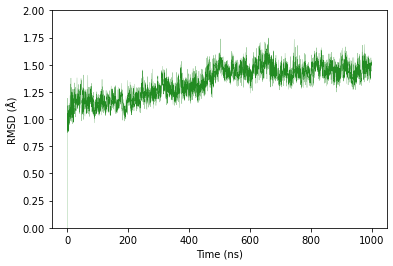

In [42]:
plt.figure()
plt.plot([TRAJECTORY_LENGTH*a/len(distances) for a in range(len(distances))], distances, linewidth=0.2, color=RMSD_COLOR)
plt.ylim(0, MAX_RMSD)
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (Å)')
plt.savefig(RMSD_PLOT_FILENAME, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
ax.grid(True)
ax.figure()
ax.plot([TRAJECTORY_LENGTH*a/len(distances) for a in range(len(distances))], distances, linewidth=0.2, color=RMSD_COLOR)
ax.ylim(0, MAX_RMSD)
ax.xlabel('Time (ns)')
ax.ylabel('RMSD (Å)')
plt.savefig(RMSD_PLOT_FILENAME, bbox_inches='tight')

## 2. All to All RMSDs

- The RSMD of each snapshot in the trajectory with respect to all others is calculated.
- This allows to identify the different states along the trajectory, which occupation is shown in the plot as a block of similar RMSD along the diagonal. [2]
- A necessary condition for good statistics is that the system is revisiting previously sampled states, which is shown in the plot as off-diagonal peaks (regions of low RMSD between structures sampled far apart in time). If these peaks doesn't appear, the simulation is considered not converged. [2]

Calculate all-to-all RMSD matrix

In [43]:
# Calculate all-to-all RMSD matrix (it could take some time if you choose a small step size!)
step_all = math.ceil(float(len(trajectory)/1000)) # Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
traj_all = trajectory[::step_all]
#traj_all = traj_all.atom_slice(SELECTION)
distances = np.empty((math.ceil(traj_all.n_frames), math.ceil(traj_all.n_frames)))
for i, frame in enumerate(range(0, traj_all.n_frames)):
    distances[i] = pt.analysis.rmsd.rmsd(traj=traj_all, mask=SELECTION, ref=i, update_coordinate=False)

Plot the data

In [44]:
#ALL_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/All_rmsd_wt_full.pdf' #Output filename for the plot

#ALL_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/All_rmsd_w434h_full.pdf' #Output filename for the plot

ALL_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/All_rmsd_w434a_full.pdf' #Output filename for the plot

MIN_RMSD_VALUE = 0.0 #It can be modified if you want to force the color scale of the plot to a predefined RMSD range
MAX_RMSD_VALUE = math.ceil(distances.max()) #It can be modified if you want to force the color scale of the plot to a predefined RMSD range

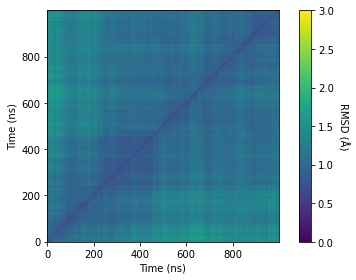

In [45]:
fig, ax = plt.subplots()
im = ax.imshow(distances, origin='lower', vmin=MIN_RMSD_VALUE, vmax=MAX_RMSD_VALUE)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('RMSD (Å)', rotation=-90, va="bottom")

ticks = np.arange(0, len(distances), len(distances)//5)
plt.xticks(ticks, [math.ceil(a*TRAJECTORY_LENGTH/len(distances)) for a in ticks])
plt.yticks(ticks, [math.ceil(a*TRAJECTORY_LENGTH/len(distances)) for a in ticks])
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Time (ns)')

fig.tight_layout()
plt.savefig(ALL_FILENAME, bbox_inches='tight')
plt.show()

## 3. PCA analysis (based on https://amber-md.github.io/pytraj/latest/tutorials/tutorial_pca.html)

Another manner to analyse the states visited along the trajectory is by creating a two component PCA model. 
It projects our data (cartesian coordinates) into a reduced dimensional space that is considered representative of the main movements of the system.

Again, a well sampled simulation would exhibit a large number of transitions among substates. [2] In this plot, this can be seen as points of different color in the same zone. For example, if a zone has purple points (corresponding to the initial part of the simulation) and yellow points (corresponding to the final part) would be an indicative of leaving and returning to this substate. As said, high number of such transitions would be a sign of good sampling.

Calculate two-Principal Component data matrix

In [46]:
step_PCA = math.ceil(float(len(trajectory)/5000)) # SI VOLS QUE AGAFI MENYS, FES MES GRAN EL NUMERO ¿O NO? Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
traj_PCA = trajectory[::step_PCA]
data = pt.pca(traj_PCA, mask=SELECTION, n_vecs=2)
projection_data = data[0]

Plot the data

In [47]:
#PCA_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/PCA_wt_full.pdf' #Output filename for the plot
#PCA_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/PCA_w434h_full.pdf' #Output filename for the plot
PCA_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/PCA_w434a_full.pdf' #Output filename for the plot


MIN_X_VALUE = math.floor(projection_data[0].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_X_VALUE = math.ceil(projection_data[0].max(axis=0)) #It can be modified if you want to force the scale of the plot
MIN_Y_VALUE = math.floor(projection_data[1].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_Y_VALUE = math.ceil(projection_data[1].max(axis=0)) #It can be modified if you want to force the scale of the plot
POINTS_SIZE = 3 #You can adjust the size of the points of the plot

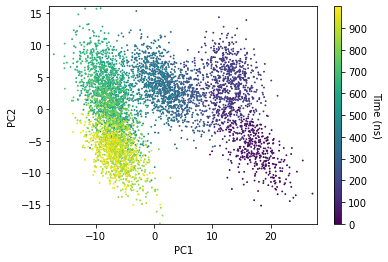

In [48]:
plt.figure()
plt.scatter(projection_data[0], projection_data[1], marker='.', c=range(len(traj_PCA)), vmin=0, vmax=len(traj_PCA), s=POINTS_SIZE)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE, MAX_X_VALUE])
plt.ylim([MIN_Y_VALUE, MAX_Y_VALUE])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(0, len(traj_PCA), len(traj_PCA)//10)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_ticklabels([math.ceil(a*TRAJECTORY_LENGTH/len(traj_PCA)) for a in ticks])
cbar.set_label('Time (ns)', rotation=-90, va="bottom")
plt.savefig(PCA_FILENAME, bbox_inches='tight')

## 4. Cluster counting as described in [3]

The main objective of a MD simulation is to sample all the conformational space that the system can explore. One manner to assess if new zones of the conformational space are being explored (and then the simulation is still not converged) is clustering all the snapshots at several points along the simulation (e.g. every 10ns) and see if the number of clusters is stabilized or still increasing.

- If new clusters are still appearing, the simulation cannot be considered converged.
- A **key parameter** is the value of **cutoff** at which we consider two structures similar (RMSD_CUTOFF). It is advisable to test different values. As an example, values of 1.0-1.5A are used in [3] in the study of a peptide, but higher values (2.0-2.5A) would be advisable for bigger systems.

Calculate distances matrix

In [20]:
step_cluster = math.ceil(float(len(trajectory)/5000)) # Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
traj_cluster = trajectory[::step_cluster]

#Calculate distances AllToAll frames (it could take some time in function of the number of frames)
distances = np.zeros((traj_cluster.n_frames, traj_cluster.n_frames))

#counter stuff
num_iter = traj_cluster.n_frames
num_updates = 20
update_per = num_iter // num_updates  # make sure it's an integer
print('|{}|'.format(' ' * (num_updates - 2)))  # gives you a reference

t0 = time.time()
for i, frame in enumerate(range(0, traj_cluster.n_frames)):
    distances[i] = pt.analysis.rmsd.rmsd(traj=traj_cluster, mask=SELECTION, ref=i, update_coordinate=False)
    #counter stuff
    if i % update_per == 0:
        print('*', end='', flush=True)
print(time.time()-t0)

|                  |
*********************312.053430557251


Calculate clusters

In [21]:
RMSD_CUTOFF = 1.5 #Distance of RMSD cutoff for cluster calculation (in Angstroms)
STEP_TIME = 10  #Time between each calculation of frames (in ns)

In [22]:
n_clusters = {}
frame = 0
step_cl = math.ceil(traj_cluster.n_frames/(TRAJECTORY_LENGTH/STEP_TIME))

while (frame + step_cl) < traj_cluster.n_frames:
    frame += step_cl
    survivors = [i for i in range(0, frame)]
    n_clusters[frame] = 0
    while(survivors):
        rows = columns = np.array(survivors, dtype=np.intp)
        surv_dist = distances[rows[:, np.newaxis], columns] #Catch the submatrix of distances of the survivor frames
        neighbours = np.zeros(len(survivors))
        for i in range(0, len(survivors)):
            neighbours[i] = len(np.where(surv_dist[i] < RMSD_CUTOFF)[0])
        cluster_center = np.argmax(neighbours, axis=0)
        to_remove = [survivors[a] for a in np.where(surv_dist[cluster_center] < RMSD_CUTOFF)[0]]
        for elem in to_remove:
            survivors.remove(elem)
        n_clusters[frame] += 1

print(n_clusters)

{50: 1, 100: 1, 150: 1, 200: 1, 250: 1, 300: 1, 350: 1, 400: 1, 450: 1, 500: 1, 550: 1, 600: 1, 650: 1, 700: 1, 750: 1, 800: 1, 850: 1, 900: 1, 950: 1, 1000: 1, 1050: 1, 1100: 1, 1150: 1, 1200: 1, 1250: 1, 1300: 1, 1350: 1, 1400: 1, 1450: 1, 1500: 1, 1550: 1, 1600: 1, 1650: 1, 1700: 1, 1750: 1, 1800: 1, 1850: 1, 1900: 1, 1950: 1, 2000: 1, 2050: 1, 2100: 1, 2150: 1, 2200: 1, 2250: 1, 2300: 1, 2350: 1, 2400: 1, 2450: 1, 2500: 1, 2550: 1, 2600: 1, 2650: 1, 2700: 1, 2750: 1, 2800: 1, 2850: 1, 2900: 1, 2950: 1, 3000: 1, 3050: 1, 3100: 1, 3150: 1, 3200: 1, 3250: 1, 3300: 1, 3350: 1, 3400: 1, 3450: 1, 3500: 1, 3550: 1, 3600: 1, 3650: 1, 3700: 1, 3750: 1, 3800: 1, 3850: 1, 3900: 1, 3950: 1, 4000: 1, 4050: 1, 4100: 1, 4150: 1, 4200: 1, 4250: 1, 4300: 1, 4350: 1, 4400: 1, 4450: 1, 4500: 1, 4550: 1, 4600: 1, 4650: 1, 4700: 1, 4750: 1, 4800: 1, 4850: 1, 4900: 1, 4950: 1}


Plot the data

In [23]:
CLUSTER_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/Cluster_wt_cutoff_1_5_full.pdf' #Output filename for the plot

#CLUSTER_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/Cluster_wt_cutoff_1_5_full.pdf' #Output filename for the plot

#CLUSTER_FILENAME = '/media/xavi/99e463f2-6cec-40d5-85bb-b6aa84b4b648/convergence_analysis/Cluster_wt_cutoff_1_5_full.pdf' #Output filename for the plot

CLUSTER_COLOR = 'orangered' #Color of the line
MAX_CLUSTERS = math.ceil(max(n_clusters.values())) + 2 #It can be modified if you want to change the scale of the plot

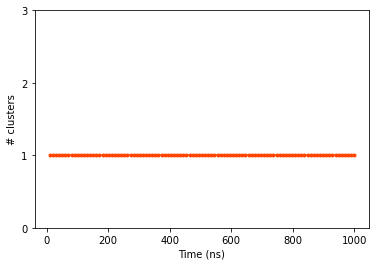

In [24]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
plt.plot([a*TRAJECTORY_LENGTH/max(n_clusters.keys()) for a in n_clusters.keys()], list(n_clusters.values()), marker='.', color=CLUSTER_COLOR)
plt.ylim(0, MAX_CLUSTERS)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Time (ns)')
plt.ylabel('# clusters')
plt.savefig(CLUSTER_FILENAME, bbox_inches='tight')